## Verify no slip boundary condition

1) Load a dataframe of particle trajectories 
2) remove any particles that are not in the right region based on the pxClassifier and some filtering
3) fit the top surface of the gel and bottom surface of the sediment to a plane after any outliers are removed.
4) Plot the displacements over time just above and below the interface 
5) Plot the distribution of a quantity that should be zero if there was no slip.

In [56]:
# preamble
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import trackpy as tp
import numpy as np

import sys
sys.path.extend(['/Users/zsolt/Colloid_git/TractionRheoscopy'])
from data_analysis import static as da

In [3]:
# some metaData paths, etc
dpl_metaPath = '/Users/zsolt/Colloid_git/TractionRheoscopy/metaDataYAML/tfrGel10212018A_shearRun10292018f_metaData.yaml'
stitched_fName_frmt = 'tfrGel10212018A_shearRun10292018f_stitched_sed_t{:03}.h5'
tracked_path = '/Users/zsolt/Colloid/DATA/tfrGel10212018x/tfrGel10212018A_shearRun10292018f/sed_stitched_maxDisp_1.2.h5'

In [4]:
# load dataframe of trackpy output (tracked)

tracked = tp.PandasHDFStoreBig(tracked_path)

#tracked = pd.read_hdf(tracked_path,'1')
#tracked.head(10)

In [20]:
# get frame 0 from tracked output
# note that there is both 'particle' column and the index. 
tracked.get(0)

,"x (um, imageStack)","y (um, imageStack)","z (um, imageStack)",frame,particle
0,28.096930,10.316645,25.167796,0,0
1,42.484647,2.705690,27.140214,0,1
2,48.602294,3.986103,27.065810,0,2
3,38.440631,6.005403,27.159629,0,3
4,47.926670,6.344692,27.114065,0,4
...,...,...,...,...,...
1157454,220.798993,187.106958,77.657198,0,963456
1157455,228.533523,199.772788,79.314110,0,963457
1157456,220.037166,232.695633,80.811141,0,963458
1157457,225.019636,208.915991,84.858652,0,963459


In [18]:
col_list = list(tracked.get(0).keys())

## load dataframe of particle trajectories (traj array)
# loadData2Mem should be updated to include keeping tracking of the original index as a column trackedIndex
# which would make loading tracked superfluous (or loading this superfluous?)
trajArray = da.loadData2Mem(tracked_path,col_list=col_list)

In [19]:
trajArray

x (um, imageStack)  y (um, imageStack)  z (um, imageStack)
frame particle                                                            
0     0                  28.096930           10.316645           25.167796
      1                  42.484647            2.705690           27.140214
      2                  48.602294            3.986103           27.065810
      3                  38.440631            6.005403           27.159629
      4                  47.926670            6.344692           27.114065
...                            ...                 ...                 ...
89    1591906           215.849582          215.849684           80.976939
      1591907           230.720364          217.263068           83.661271
      1591908           189.146933          225.644107           84.754404
      1591909           186.748290          226.678633           83.714706
      1591910           230.502905          208.799177           85.344078

[87000272 rows x 3 columns]

In [24]:
# load dataframe of stitched output with pxClassifier channels (stitched)
frame = 0
mat = 'sed'
stitchedPath = '/Users/zsolt/Colloid/DATA/tfrGel10212018x/tfrGel10212018A_shearRun10292018f/locations'
stitched_fName_frmt = 'tfrGel10212018A_shearRun10292018f_stitched_{}'.format(mat)+'_t{:03}.h5'
_fName = stitchedPath + '/' + stitched_fName_frmt.format(frame)
stitched = pd.read_hdf(_fName, key='{}'.format(frame))

In [26]:
stitched[stitched['keepBool'] == True]

,index,"z (px, hash)","y (px, hash)","x (px, hash)",mass,size,ecc,signal,raw_mass,ep,...,sed_Background_shell,fluorescent_chunk_shell,nonfluorescent_chunk_shell,hashValue,material,"x (um, imageStack)","y (um, imageStack)","z (um, imageStack)",totalError,keepBool
0,0,10.785308,79.709955,234.321127,9.059345e+05,2.951350,NaN,12665.579849,9.609475e+05,1.757228e-06,...,233.639999,14.03,8.89,50,sed,28.096930,10.316645,25.167796,0.019610,True
1,1,23.934760,13.527743,359.431709,3.164587e+06,3.788125,NaN,13934.800939,3.271568e+06,5.161449e-07,...,636.860002,8.95,1.62,50,sed,42.484647,2.705690,27.140214,0.019525,True
2,2,23.438735,24.661763,412.628646,4.204505e+06,3.711515,NaN,16409.878696,4.312216e+06,3.915860e-07,...,583.920002,7.36,1.04,50,sed,48.602294,3.986103,27.065810,0.019005,True
3,3,24.064191,42.220895,324.266360,3.545237e+06,3.526261,NaN,18757.958715,3.641405e+06,4.637231e-07,...,665.460003,8.89,1.15,50,sed,38.440631,6.005403,27.159629,0.013912,True
4,4,23.760432,45.171231,406.753651,3.715293e+06,3.689225,NaN,14815.332104,3.823265e+06,4.416653e-07,...,591.590002,9.78,1.17,50,sed,47.926670,6.344692,27.114065,0.018530,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1157454,11,104.714653,19.017026,311.991242,8.216540e+05,2.559439,NaN,11043.803104,8.577018e+05,4.244415e-05,...,550.119999,16.66,16.41,124,sed,220.798993,187.106958,77.657198,0.023103,True
1157455,12,115.760734,129.154674,379.248030,7.238338e+05,2.546243,NaN,10063.376670,7.556932e+05,4.817358e-05,...,557.660001,10.53,13.81,124,sed,228.533523,199.772788,79.314110,0.025896,True
1157456,13,125.740937,415.440290,305.366663,2.627579e+05,2.436420,NaN,4807.434192,2.915593e+05,1.248620e-04,...,561.930001,22.55,33.67,124,sed,220.037166,232.695633,80.811141,0.052559,True
1157457,14,152.724347,208.660791,348.692491,2.659710e+05,2.280498,NaN,4902.967507,2.910666e+05,1.250733e-04,...,337.830000,6.70,4.74,124,sed,225.019636,208.915991,84.858652,0.050735,True


In [28]:
# example calculation of finding the trajectory with the largest avg nonfluorescent chunk signal
stitched[stitched['keepBool'] == True]['fluorescent_chunk_core'].describe()

count    963461.000000
mean          1.351166
std           1.668450
min           0.000000
25%           0.480000
50%           0.930000
75%           1.750000
max          88.950000
Name: fluorescent_chunk_core, dtype: float64

/Users/zsolt/.conda/envs/tractionRheoscopy/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='fluorescent_chunk_core', ylabel='Density'>

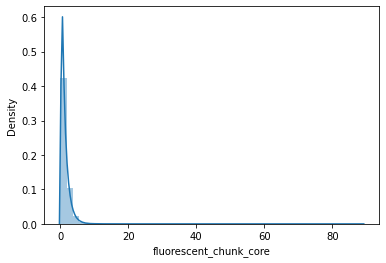

In [31]:
sns.distplot(stitched[stitched['keepBool'] == True]['fluorescent_chunk_core'])

In [32]:
stitched[(stitched['keepBool'] == True) & (stitched['fluorescent_chunk_core'] > 10)]

,index,"z (px, hash)","y (px, hash)","x (px, hash)",mass,size,ecc,signal,raw_mass,ep,...,sed_Background_shell,fluorescent_chunk_shell,nonfluorescent_chunk_shell,hashValue,material,"x (um, imageStack)","y (um, imageStack)","z (um, imageStack)",totalError,keepBool
418,418,28.334306,212.553871,25.463737,7.678628e+06,4.320889,NaN,14922.979342,7.803557e+06,2.163889e-07,...,576.510003,20.11,1.15,50,sed,4.078330,25.593695,27.800146,0.018220,True
601,601,28.472736,349.780679,225.205290,6.981398e+06,3.934652,NaN,21680.880575,7.102810e+06,2.377374e-07,...,380.389999,65.40,16.44,50,sed,27.048608,41.374778,27.820910,0.013260,True
610,610,28.481205,375.223271,204.328156,6.004350e+06,3.874261,NaN,21120.424988,6.118874e+06,2.759664e-07,...,289.630000,109.15,100.99,50,sed,24.647738,44.300676,27.822181,0.013379,True
685,685,28.442586,383.545464,226.505499,8.571851e+06,4.219611,NaN,24647.854047,8.692217e+06,1.942661e-07,...,351.499999,50.82,195.03,50,sed,27.198132,45.257728,27.816388,0.011954,True
973,973,35.268097,207.114508,363.152046,6.157744e+06,4.566107,NaN,11520.963502,6.276228e+06,2.690475e-07,...,621.580002,26.29,1.04,50,sed,42.912485,24.968168,28.840215,0.024771,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1152194,10390,141.071136,419.928001,11.107940,6.201587e+06,3.573722,NaN,30130.535253,6.314954e+06,1.324315e-05,...,481.140000,17.46,14.28,124,sed,186.197413,233.211720,83.110670,0.008843,True
1152494,10690,145.024310,108.755359,32.601530,5.178937e+06,3.272339,NaN,34127.840297,5.275388e+06,1.585285e-05,...,391.759999,13.72,19.03,124,sed,188.669176,197.426866,83.703646,0.007661,True
1152779,10975,141.928791,240.161902,65.453991,3.861578e+06,3.730974,NaN,22631.032457,3.962100e+06,2.110749e-05,...,393.680000,61.35,21.25,124,sed,192.447209,212.538619,83.239319,0.011668,True
1156808,3665,143.583537,246.614107,32.183836,1.504789e+05,1.943142,NaN,3629.914262,1.649187e+05,3.553721e-04,...,391.999999,24.29,25.37,124,sed,188.621141,213.280622,83.487530,0.062657,True


/Users/zsolt/.conda/envs/tractionRheoscopy/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='fluorescent_chunk_core', ylabel='Density'>

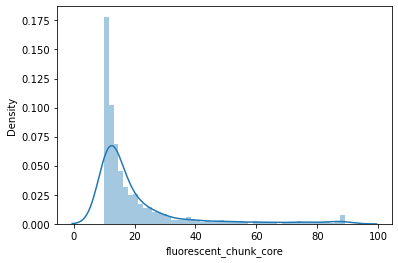

In [33]:
sns.distplot(stitched[(stitched['keepBool'] == True) & (stitched['fluorescent_chunk_core'] > 10)]['fluorescent_chunk_core'])

/Users/zsolt/.conda/envs/tractionRheoscopy/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='fluorescent_chunk_core', ylabel='Density'>

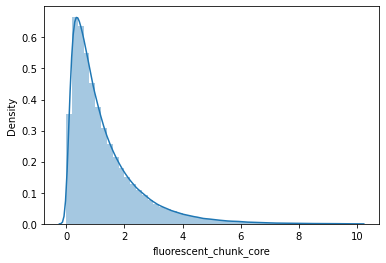

In [34]:
sns.distplot(stitched[(stitched['keepBool'] == True) & (stitched['fluorescent_chunk_core'] < 10)]['fluorescent_chunk_core'])

/Users/zsolt/.conda/envs/tractionRheoscopy/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sed_Background_shell', ylabel='Density'>

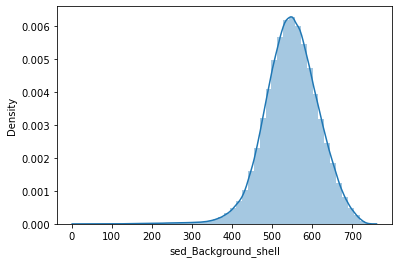

In [39]:
sns.distplot(stitched[(stitched['keepBool'] == True) & (stitched['fluorescent_chunk_core'] < 10)]['sed_Background_shell'])

/Users/zsolt/.conda/envs/tractionRheoscopy/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sed_Background_shell', ylabel='Density'>

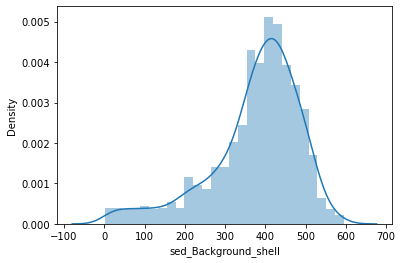

In [43]:
sns.distplot(stitched[(stitched['keepBool'] == True) & (stitched['fluorescent_chunk_shell'] > 100)]['sed_Background_shell'])

/Users/zsolt/.conda/envs/tractionRheoscopy/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='fluorescent_chunk_shell', ylabel='Density'>

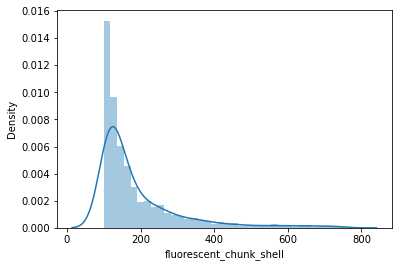

In [46]:
sns.distplot(stitched[(stitched['keepBool'] == True) & (stitched['fluorescent_chunk_shell'] > 100)]['fluorescent_chunk_shell'])

In [47]:
tmp = stitched[(stitched['keepBool'] == True)]

In [52]:
tmp['sedColloid/fluorChunk'] = tmp['fluorescent_chunk_core']/tmp['sed_Colloid_core']

/Users/zsolt/.conda/envs/tractionRheoscopy/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [57]:
tmp['sedColloid/fluorChunk'].replace([np.inf, -np.inf], np.nan, inplace=True)

/Users/zsolt/.conda/envs/tractionRheoscopy/lib/python3.7/site-packages/pandas/core/series.py:4515: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [58]:
tmp['sedColloid/fluorChunk'].describe()

count    963459.000000
mean          0.093810
std           9.702191
min           0.000000
25%           0.023394
50%           0.047760
75%           0.089854
max        8895.000204
Name: sedColloid/fluorChunk, dtype: float64

<AxesSubplot:xlabel='sedColloid/fluorChunk', ylabel='Density'>

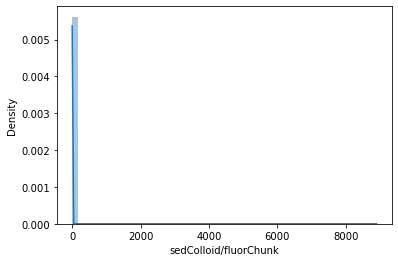

In [59]:
sns.distplot(tmp['sedColloid/fluorChunk'])

In [60]:
tmp[tmp['sedColloid/fluorChunk']> 10]

,index,"z (px, hash)","y (px, hash)","x (px, hash)",mass,size,ecc,signal,raw_mass,ep,...,fluorescent_chunk_shell,nonfluorescent_chunk_shell,hashValue,material,"x (um, imageStack)","y (um, imageStack)","z (um, imageStack)",totalError,keepBool,sedColloid/fluorChunk
2837,2837,64.606209,182.769977,263.870906,1.514924e+07,4.717984,NaN,1.282247e+04,1.526887e+07,1.105912e-07,...,70.130000,5.48,50,sed,31.495154,22.168547,33.240931,0.024002,True,13.306035
4518,4518,91.675655,132.501419,399.744307,2.387380e+07,4.776583,NaN,2.325726e+04,2.399874e+07,7.036216e-08,...,160.640000,16.50,50,sed,47.120595,16.387663,37.301348,0.011756,True,10.704385
13613,344,94.769172,128.482269,400.187518,1.934010e+05,4.334375,NaN,5.931557e+03,2.063264e+05,5.281505e-04,...,169.910000,21.62,50,sed,47.171565,15.925461,37.765376,NaN,True,11.221037
28589,0,7.314788,242.847151,70.976526,1.816075e+07,5.207637,NaN,8.275992e+03,1.828261e+07,6.617580e-09,...,393.210000,5.74,52,sed,101.197300,29.077422,24.647218,0.052558,True,27.075631
30795,2206,46.337988,274.608867,145.876434,2.001443e+07,4.792049,NaN,2.701345e+04,2.013586e+07,6.008514e-09,...,207.830000,21.49,52,sed,109.810790,32.730020,30.500698,0.012451,True,14.642726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342650,6,69.673920,408.130195,304.683165,3.131149e+05,4.074728,NaN,8.101091e+03,3.322769e+05,2.553465e-04,...,307.170001,44.19,74,sed,219.958564,231.854972,34.001088,0.035043,True,18.886935
963803,5012,147.197441,268.952468,366.138940,7.839945e+04,2.372912,NaN,1.000000e-07,9.235859e+04,1.090917e-03,...,68.770000,17.31,112,sed,135.140978,123.964534,84.029616,NaN,True,11.279070
963806,5015,156.506849,17.314009,169.311490,8.370252e+04,2.341554,NaN,3.925645e+03,1.015738e+05,9.919168e-04,...,33.060000,49.08,112,sed,112.505821,95.026111,85.426027,NaN,True,12.548387
1046733,4845,154.368037,157.918400,405.994157,1.704456e+05,2.311509,NaN,6.742845e+03,1.879177e+05,1.814191e-04,...,133.550000,70.88,117,sed,139.724328,157.080616,85.105205,NaN,True,15.184616


<AxesSubplot:xlabel='fluorescent_chunk_core', ylabel='Count'>

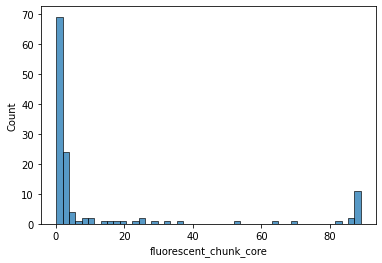

In [76]:
sns.histplot(tmp[tmp['sed_Colloid_shell'] < 7]['fluorescent_chunk_core'])

<AxesSubplot:xlabel='gel_Tracer_core', ylabel='Count'>

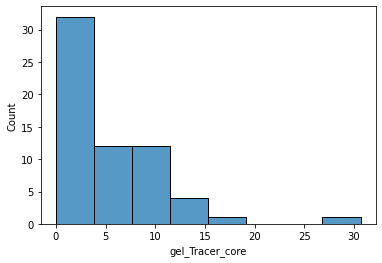

In [79]:
sns.histplot(tmp[tmp['sed_Colloid_shell'] < 5]['gel_Tracer_core'])

(array([[44., 16.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [14.,  5.,  9.,  7.,  7.,  4.,  2.,  6.,  7.,  1.],
        [27.,  8.,  7.,  5.,  9.,  2.,  2.,  0.,  1.,  1.]]),
 array([ 0.        ,  8.00500001, 16.01000003, 24.01500004, 32.02000005,
        40.02500007, 48.03000008, 56.03500009, 64.0400001 , 72.04500012,
        80.05000013]),
 <a list of 3 BarContainer objects>)

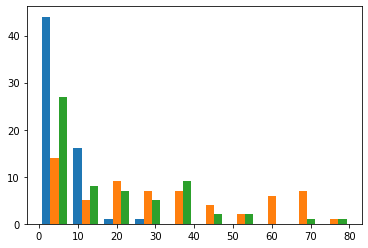

In [80]:
plt.hist(tmp[tmp['sed_Colloid_shell'] < 5][['gel_Tracer_core', 'sed_Background_core', 'gel_Background_core']])

In [81]:
tmp[tmp['sed_Colloid_shell'] < 7]

,index,"z (px, hash)","y (px, hash)","x (px, hash)",mass,size,ecc,signal,raw_mass,ep,...,fluorescent_chunk_shell,nonfluorescent_chunk_shell,hashValue,material,"x (um, imageStack)","y (um, imageStack)","z (um, imageStack)",totalError,keepBool,sedColloid/fluorChunk
38174,73,28.608369,99.105235,360.827471,2.180221e+06,2.986438,NaN,18244.531178,2.243940e+06,0.000067,...,4.700000,4.57,52,sed,134.530159,12.547102,27.841255,0.013860,True,0.083333
40519,2418,95.926959,176.204034,405.518633,1.911978e+06,2.948015,NaN,17162.358635,1.968292e+06,0.000076,...,639.690002,21.79,52,sed,139.669643,21.413464,37.939044,0.015010,True,4.136170
53203,62,27.931173,13.748547,147.658278,1.579324e+06,2.967334,NaN,14777.852860,1.621127e+06,0.000081,...,232.360000,87.68,53,sed,155.900702,2.731083,27.739676,0.013981,True,0.089192
57652,11,27.319063,18.129112,153.537002,8.406543e+05,3.969025,NaN,17482.889580,8.689213e+05,0.000099,...,725.230004,3.92,53,sed,156.576755,3.234848,27.647859,16.101565,True,48.510490
57696,55,38.272988,114.712595,66.131137,1.329879e+06,2.856433,NaN,11520.942537,1.368335e+06,0.000063,...,561.920002,46.97,53,sed,146.525081,14.341948,29.290948,0.018914,True,2.559643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1125926,4859,153.620979,347.265175,288.069111,5.952832e+05,3.084391,NaN,10028.208486,6.462006e+05,0.000150,...,23.140000,19.89,122,sed,126.162948,224.855495,84.993147,NaN,True,4.417355
1125953,4886,153.940930,405.883697,257.293169,2.665415e+05,3.251056,NaN,5970.521420,3.104133e+05,0.000312,...,11.550000,16.33,122,sed,122.623714,231.596625,85.041139,NaN,True,4.244565
1125987,4920,154.817931,397.030753,324.648001,1.549660e+05,3.111935,NaN,5027.135380,1.846700e+05,0.000524,...,32.750000,29.62,122,sed,130.369520,230.578537,85.172690,NaN,True,8.633333
1154632,1489,60.722494,354.160655,29.094769,1.639560e+06,2.654932,NaN,19102.167705,1.681425e+06,0.000035,...,0.130000,117.83,124,sed,188.265898,225.648475,71.058374,0.013534,True,0.119938


In [87]:
tmp.keys()

Index(['index', 'z (px, hash)', 'y (px, hash)', 'x (px, hash)', 'mass', 'size',
       'ecc', 'signal', 'raw_mass', 'ep', 'n_iteration', 'frame', 'cluster',
       'cluster_size', 'disc_size', 'size_x', 'size_y', 'size_z', 'background',
       'background_std', 'signal_std', 'z_std', 'y_std', 'x_std', 'cost',
       'gel_Background_core', 'gel_Tracer_core', 'sed_Colloid_core',
       'sed_Background_core', 'fluorescent_chunk_core',
       'nonfluorescent_chunk_core', 'gel_Background_shell', 'gel_Tracer_shell',
       'sed_Colloid_shell', 'sed_Background_shell', 'fluorescent_chunk_shell',
       'nonfluorescent_chunk_shell', 'hashValue', 'material',
       'x (um, imageStack)', 'y (um, imageStack)', 'z (um, imageStack)',
       'totalError', 'keepBool', 'sedColloid/fluorChunk'],
      dtype='object')

In [109]:
#tmp.keys()[4:5]
pxClassifier_keys = tmp.keys()[25:37].union(tmp.keys()[4:5])

In [129]:
searchfor = ['_core', 'mass', 'imageStack']
s = tmp.keys()
pxClassifier_keys = s[s.str.contains('|'.join(searchfor))]

In [136]:
tmp[tmp['sed_Colloid_core'] < 5][pxClassifier_keys].sort_values(by=['fluorescent_chunk_core'],ascending=False).head(50)

,mass,raw_mass,gel_Background_core,gel_Tracer_core,sed_Colloid_core,sed_Background_core,fluorescent_chunk_core,nonfluorescent_chunk_core,"x (um, imageStack)","y (um, imageStack)","z (um, imageStack)"
289205,1.829200e+07,1.839852e+07,0.00,0.03,0.01,0.01,88.950000,0.00,17.006487,221.847848,33.508343
292120,1.378613e+06,1.402523e+06,0.00,0.02,0.11,0.04,88.830000,0.00,27.079401,212.299532,33.724643
313224,1.608762e+07,1.618228e+07,0.00,0.01,0.10,0.11,88.780000,0.00,129.817068,198.408693,33.019313
292590,6.478904e+05,6.619110e+05,0.00,0.04,0.08,0.13,88.750000,0.00,25.967799,207.850551,33.772438
292095,2.242240e+05,2.388495e+05,0.00,0.09,0.05,0.11,88.750000,0.00,26.464190,212.335825,33.768362
292102,3.156110e+06,3.197532e+06,0.00,0.03,0.15,0.08,88.740000,0.00,26.387540,208.003192,33.932128
306133,2.330101e+07,2.342223e+07,0.00,0.12,0.09,0.08,88.710000,0.00,129.956336,197.905391,31.835337
58422,5.370166e+05,5.494121e+05,0.00,0.15,0.12,0.03,88.700000,0.00,141.171808,22.455980,38.475532
317252,9.645069e+05,9.937367e+05,0.01,0.02,0.24,0.04,88.690000,0.00,129.108202,198.252042,32.771579
317289,4.712120e+05,4.872239e+05,0.00,0.19,0.00,0.29,88.520000,0.00,129.578896,197.171163,32.895296


In [138]:
tmp[tmp['sed_Colloid_core'] < 5][pxClassifier_keys].sort_values(by=['gel_Tracer_core'],ascending=False).head(50)

,mass,raw_mass,gel_Background_core,gel_Tracer_core,sed_Colloid_core,sed_Background_core,fluorescent_chunk_core,nonfluorescent_chunk_core,"x (um, imageStack)","y (um, imageStack)","z (um, imageStack)"
292079,1.115010e+06,1.169455e+06,1.58,52.95,1.75,11.85,20.86,0.01,2.565197,199.066646,32.786205
28589,1.816075e+07,1.828261e+07,0.01,52.58,1.19,2.42,32.22,0.58,101.197300,29.077422,24.647218
235470,8.541829e+06,8.638170e+06,0.00,49.98,0.84,2.63,34.80,0.75,94.361708,155.631162,26.689315
239582,2.780240e+06,2.834786e+06,0.00,41.62,1.05,1.47,44.37,0.49,94.617668,155.954926,25.591280
1125908,7.399893e+05,8.018605e+05,31.02,37.24,2.12,9.83,5.13,3.66,132.998858,218.581061,85.135399
227519,1.444902e+07,1.457231e+07,0.09,37.09,1.38,2.08,48.00,0.36,95.009371,155.039142,26.818473
240514,1.789743e+05,1.949374e+05,0.00,36.32,2.70,1.71,47.80,0.47,94.538111,156.055778,26.230082
9019,1.153880e+05,1.274224e+05,20.32,32.45,0.09,34.97,0.26,0.91,29.082704,29.617821,26.207005
1125873,1.656533e+05,1.980481e+05,35.59,25.88,1.40,9.54,9.23,7.36,136.576039,226.027680,84.843861
1125912,3.298104e+05,3.637977e+05,36.30,24.71,0.67,17.08,3.46,6.78,140.429107,220.011261,84.984089
